# Homework 4 - Applied ML

In [1]:
# Panda
import numpy as np
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Utils
import collections
from pprint import pprint
from dateutil import relativedelta
from datetime import date

# sickit
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing

# 0 - Prepare data

In [2]:
soccer_data = pd.read_csv('CrowdstormingDataJuly1st.csv', sep=',', parse_dates=['birthday'])
soccer_data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,1983-08-31,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,1982-08-01,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,1992-12-17,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,1993-08-31,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,1991-07-18,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


First, we must understand data we will use and clean them if needed.

A detailed description of each columns is provided in the file DATA.md. We invite the reader to take note of these descriptions before continuing.

A first modification that we propose to do is to compute the age of players according to the given birthday date. Thus, we'll use this feature if needed instead of the birthday's column (which is quite understandable as we use a random forest where each decision tree will split data according to the values). To keep futur model, we would made, usable with other data, we prefere compute the age with the moment when data has been collected.  

In [3]:
def compute_age(row):
    '''
    Given a player, function returns the years of player.
    
    row: Row of the DataFrame, representing a dyad which contains a player.
    '''
    data_date = date(2013, 1, 1)
    delta = relativedelta.relativedelta(data_date, row['birthday'])
    return delta.years

soccer_data['age'] = soccer_data.apply(compute_age, axis=1)
soccer_data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,age
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,1983-08-31,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,29
1,john-utaka,John Utaka,Montpellier HSC,France,1982-08-01,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,30
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,1992-12-17,181.0,79.0,NaN,1,0,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,20
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,1993-08-31,191.0,87.0,Center Back,1,1,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,19
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,1991-07-18,172.0,70.0,Right Midfielder,1,1,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,21


Here, as we want to determine the skin color of a player according to given data, it is important that at least one rater has given a note.

In [4]:
soccer_data['rater1'].value_counts(dropna=False)

 0.00    49774
 0.25    43708
NaN      21407
 0.50    13518
 0.75     9501
 1.00     8120
Name: rater1, dtype: int64

In [5]:
soccer_data['rater2'].value_counts(dropna=False)

 0.25    56483
 0.00    35712
NaN      21407
 0.50    12650
 0.75     9915
 1.00     9861
Name: rater2, dtype: int64

As we can see, there is some players for whom there is no rater 1 or rater 2 (in particular, here, it seems that when there is no rater 1, there is no rater 2).

We decide to remove all dyad when we don't have any note.

Note: We could have chose to drop all rows where there is no photo ID, but it is better to consider directly raters instead, as in theory (!) nothing prevents having a photo ID but for a player but no raters.

In [6]:
soccer_data_clean = soccer_data[soccer_data['rater1'].notnull() | soccer_data['rater2'].notnull()].copy()
soccer_data_clean.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,age
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,1983-08-31,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,29
1,john-utaka,John Utaka,Montpellier HSC,France,1982-08-01,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,30
5,aaron-hughes,Aaron Hughes,Fulham FC,England,1979-08-11,182.0,71.0,Center Back,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,33
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,1985-10-11,187.0,80.0,Left Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,27
7,alexander-tettey,Alexander Tettey,Norwich City,England,1986-04-04,180.0,68.0,Defensive Midfielder,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,26


In [7]:
soccer_data_clean['rater2'].value_counts(dropna=False)

0.25    56483
0.00    35712
0.50    12650
0.75     9915
1.00     9861
Name: rater2, dtype: int64

In [8]:
soccer_data_clean['rater1'].value_counts(dropna=False)

0.00    49774
0.25    43708
0.50    13518
0.75     9501
1.00     8120
Name: rater1, dtype: int64

As we can see, votes are quite often different between the two raters. Thus, we decide to combine these data to have an unique note.

Here, we suppose that raters' votes are independent (no influence on votes between the two raters) and that raters were honest, for lack of exactitude. So, we used the mean to compute this unique note.

In [9]:
soccer_data_clean['rater'] = np.floor(soccer_data_clean[['rater1', 'rater2']].mean(axis=1) * 100)

In [10]:
soccer_data_clean['rater'].value_counts(dropna=False)

25.0     38517
0.0      33723
12.0     17876
50.0      8989
100.0     7570
75.0      7079
37.0      5609
87.0      2841
62.0      2417
Name: rater, dtype: int64

Now, let's display if there are any null values in the data.

In [11]:
soccer_data_clean.isnull().sum()

playerShort         0
player              0
club                0
leagueCountry       0
birthday            0
height             46
weight            753
position         8461
games               0
victories           0
ties                0
defeats             0
goals               0
yellowCards         0
yellowReds          0
redCards            0
photoID             0
rater1              0
rater2              0
refNum              0
refCountry          0
Alpha_3             1
meanIAT           153
nIAT              153
seIAT             153
meanExp           153
nExp              153
seExp             153
age                 0
rater               0
dtype: int64

For position, we do nothing at this stage. However, for height and weight, we decide to use mean of values to replace null values.

In [12]:
soccer_data_clean[['height', 'weight']] = soccer_data_clean[['height', 'weight']].fillna(soccer_data_clean[['height', 'weight']].mean())

IAT and Explicit bias scores are very important, so we decide to drop any dyad where these values are missing.

In [13]:
soccer_data_clean = soccer_data_clean[soccer_data_clean['meanIAT'].notnull() & soccer_data_clean['meanExp'].notnull()].copy()

Let's describe all data related to IAT and Explicit bias scores.

In [14]:
soccer_data_clean[['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']].describe()

,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
count,124468.000000,1.244680e+05,1.244680e+05,124468.000000,1.244680e+05,124468.000000
mean,0.348123,1.817187e+04,6.287461e-04,0.463797,1.884147e+04,0.002988
std,0.032087,1.261437e+05,4.788647e-03,0.219206,1.296022e+05,0.019719
min,-0.047254,2.000000e+00,2.235373e-07,-1.375000,2.000000e+00,0.000001
25%,0.334684,1.785000e+03,5.454025e-05,0.336101,1.897000e+03,0.000225
50%,0.336628,2.882000e+03,1.508847e-04,0.356446,3.011000e+03,0.000586
75%,0.369894,7.749000e+03,2.294896e-04,0.588297,7.974000e+03,0.001002
max,0.573793,1.975803e+06,2.862871e-01,1.800000,2.029548e+06,1.060660


In [15]:
soccer_data_clean['associationScore'] = (soccer_data_clean['meanIAT'] + soccer_data_clean['meanExp']) / 2
soccer_data_clean.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,age,rater,associationScore
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,1983-08-31,177.0,72.0,Attacking Midfielder,1,0,...,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,29,37.0,0.361196
1,john-utaka,John Utaka,Montpellier HSC,France,1982-08-01,179.0,82.0,Right Winger,1,0,...,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,30,75.0,-0.000353
5,aaron-hughes,Aaron Hughes,Fulham FC,England,1979-08-11,182.0,71.0,Center Back,1,0,...,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,33,12.0,0.431823
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,1985-10-11,187.0,80.0,Left Fullback,1,1,...,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,27,12.0,0.431823
7,alexander-tettey,Alexander Tettey,Norwich City,England,1986-04-04,180.0,68.0,Defensive Midfielder,1,0,...,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,26,100.0,0.431823


<p style="color:red;">To schematize, there are four cases we may consider, for each player, regarding skin color and IAT and Explicit bias scores' influence.

1. Referee's country has a positive score (IAT or Explicit bias) and player is black (rate from 0.5 to 1).
2. Referee's country has a positive score (IAT or Explicit bias) and player is white (rate 0 to 0.5).
3. Referee's country has a negative score (IAT or Explicit bias) and player is black (rate from 0.5 to 1).
4. Referee's country has a negative score (IAT or Explicit bias) and player is white (rate from 0 to 0.5).

Note: We remind that a positive score for IAT or Explicit bias corresponds to faster white | good, black | bad associations and to greater feelings of warmth toward whites versus blacks (respectively). The countrary is true if score is negative.

Now, we must make some assumptions and important decisions.

The first case will be the case we'll focus on the most. Indeed, we assume that there are some correlation between the number of red/yellow cards given to a player and the referee's country (and it is basically why IAT and Explicit bias are given here). Thus, in such case, we'll increase number of yellow/red cards to take into account the bias.

The other cases are not really interesting. For example, for the second and third cases, we assume here that if a yellow/red card was given, the skin color of the player was not taken into account.

We don't deny that it is possible for a referee to not give a yellow/red card even if he must had to, because the player's skin color is the same as the one which is "favourite" (second and third cases), or that a referee gave more yellow/red cards to a white player because his "favourite" skin color is black (opposite of the first case), but if we also increase the number of cards given it would be difficult to highlight some racism behaviour and to entirely use the number of red/yellow cards (increasing data in these four cases would simply shift values).

Note: Our decision is subjective, but describe the most actual problems in soccer (it is more common to have racism with black players than with white players). Also, the major part of referees are from countries where white people are the majority (Europe, North America):
</p>

In [16]:
soccer_data_clean[['refNum', 'Alpha_3']].drop_duplicates('refNum')['Alpha_3'].value_counts()

DEU     573
ESP     176
ENGL    173
ITA     111
BRA      89
FRA      86
TUR      75
BEL      67
GRC      64
AUT      58
ARG      52
PRT      50
RUS      46
ROU      46
MEX      46
CHE      44
NLD      44
POL      41
UKR      39
SRB      38
SCOT     37
HRV      37
USA      36
CZE      34
BGR      33
JPN      31
SWE      31
DNK      29
KOR      28
AUS      28
       ... 
PYF       2
MDG       2
BEN       2
ETH       2
BGD       1
SYR       1
COD       1
ABW       1
TKM       1
VUT       1
HTI       1
CAF       1
OMN       1
MOZ       1
NPL       1
TZA       1
PRI       1
PRK       1
GNQ       1
CUB       1
LIE       1
CYM       1
CPV       1
LKA       1
NER       1
IND       1
NCL       1
DOM       1
SLB       1
LBR       1
Name: Alpha_3, dtype: int64

We define a function that will increase the number of yellow/red cards iff a player is black, and this for each dyad.

In [17]:
def pondered_number_of_cards(row, cardsName):
    '''
    Given a player, function analyzes the skin color and ponderates the number of received cards if player is black.
    
    row: Row of the DataFrame, representing a dyad which contains a player.
    cardsName: Type of received cards for the player
    '''

    nbCards = row[cardsName]
    
    if row['associationScore'] > 0:
        coef = (row['rater'] / 100) * row['associationScore']
    elif row['associationScore'] < 0:
        coef = (1 - (row['rater'] / 100) ) * row['associationScore']
    else:
        coef = 0

    nbCards += nbCards * coef

    return nbCards

soccer_data_clean['ponderedYellowCards'] = soccer_data_clean.apply(func=pondered_number_of_cards, args=('yellowCards',), axis=1)
soccer_data_clean['ponderedYellowReds'] = soccer_data_clean.apply(func=pondered_number_of_cards, args=('yellowReds',), axis=1)
soccer_data_clean['ponderedRedCards'] = soccer_data_clean.apply(func=pondered_number_of_cards, args=('redCards',), axis=1)

In [18]:
soccer_data_clean[['yellowCards', 'yellowReds', 'redCards', 'ponderedYellowCards', 'ponderedYellowReds', 'ponderedRedCards']].describe()

,yellowCards,yellowReds,redCards,ponderedYellowCards,ponderedYellowReds,ponderedRedCards
count,124468.000000,124468.000000,124468.000000,124468.000000,124468.000000,124468.000000
mean,0.399516,0.012075,0.012766,0.443286,0.013510,0.014297
std,0.822019,0.111119,0.113970,0.911408,0.125015,0.128295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,14.000000,3.000000,2.000000,14.000000,3.359322,2.683135


Then, we sum all the statistics as we want to have one row for each player.

In [19]:
global_statistics = soccer_data_clean[['playerShort', 'games', 'victories', 'defeats', 'goals', 'ponderedYellowCards', 'ponderedYellowReds', 'ponderedRedCards']].groupby('playerShort').sum()
global_statistics.head()

,games,victories,defeats,goals,ponderedYellowCards,ponderedYellowReds,ponderedRedCards
playerShort,,,,,,,
aaron-hughes,654,247,228,9,19.879069,0.000000,0.000000
aaron-hunt,336,141,122,62,43.838591,0.000000,1.040356
aaron-lennon,412,200,115,31,12.009483,0.000000,0.000000
aaron-ramsey,260,150,68,39,31.000000,0.000000,1.000000
abdelhamid-el-kaoutari,124,41,43,1,8.670785,4.351369,2.167696


Finally, we create our final DataFrame containing information about a player and some statistics for his career.

In [48]:
players = soccer_data_clean.groupby('playerShort').first()
soccer_data_final = global_statistics.join(players[['age', 'height', 'weight', 'rater']])

for feature in ['club', 'leagueCountry', 'position']:
    global_statistics = global_statistics.merge(pd.get_dummies(players[feature]), left_index=True, right_index=True)

soccer_data_final_all_features = global_statistics.join(players[['age', 'height', 'weight', 'rater']])
soccer_data_final_all_features.head()

,games,victories,defeats,goals,ponderedYellowCards,ponderedYellowReds,ponderedRedCards,1. FC Nürnberg_x,1. FSV Mainz 05_x,1899 Hoffenheim_x,...,Left Fullback_y,Left Midfielder_y,Left Winger_y,Right Fullback_y,Right Midfielder_y,Right Winger_y,age,height,weight,rater
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,654,247,228,9,19.879069,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33,182.0,71.0,12.0
aaron-hunt,336,141,122,62,43.838591,0.000000,1.040356,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,26,183.0,73.0,12.0
aaron-lennon,412,200,115,31,12.009483,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,25,165.0,63.0,25.0
aaron-ramsey,260,150,68,39,31.000000,0.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,22,178.0,76.0,0.0
abdelhamid-el-kaoutari,124,41,43,1,8.670785,4.351369,2.167696,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,22,180.0,73.0,25.0


Important note:

At the end of this part, DataFrame's size was substantially reduced. However, we draw reader's attention on the fact that either we created new features which includes data from previous features (it's the case for the ponderation of cards, which uses IAT and Explicit bias scores for example) or we dropped features which are not useful for what we plan to do (like the photoID or the refNum), so we can safely continue our analysis.

# 1 - From player description to skin color

**Train a sklearn.ensemble.RandomForestClassifier that given a soccer player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the feature_importances_ attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different feature_importances_ attribute?**

First, we use categorical data for skin color as it will be the feature used as output here.

In [49]:
soccer_data_final['rater'] = pd.cut(soccer_data_final['rater'], [0, 26, 51, 76, 101], labels=['very light skin','light skin','dark skin','very dark skin'], right=False)

In [50]:
soccer_data_final['rater'].value_counts(dropna=False)

very light skin    1123
light skin          193
dark skin           137
very dark skin      132
Name: rater, dtype: int64

(See useful links below for source.)

In [51]:
features = [col for col in soccer_data_final.columns if col not in ['rater']]
print(features)

['games', 'victories', 'defeats', 'goals', 'ponderedYellowCards', 'ponderedYellowReds', 'ponderedRedCards', '1. FC Nürnberg', '1. FSV Mainz 05', '1899 Hoffenheim', 'AC Ajaccio', 'AS Nancy', 'AS Saint-Étienne', 'Arsenal FC', 'Arsenal FC (R)', 'Aston Villa', 'Athletic Bilbao', 'Atlético Madrid', 'Bayer Leverkusen', 'Bayern München', 'Blackburn Rovers', 'Bolton Wanderers', 'Bor. Mönchengladbach', 'Borussia Dortmund', 'Bristol City', 'CA Osasuna', 'CF Badalona', 'Celta Vigo', 'Chelsea FC', 'Crewe Alexandra', 'Deportivo La Coruña', 'ESTAC Troyes', 'Eintracht Frankfurt', 'Espanyol Barcelona', 'Everton FC', 'FC Augsburg', 'FC Barcelona', 'FC Lorient', 'FC Schalke 04', 'FC Sochaux', 'Fortuna Düsseldorf', 'Fulham FC', 'Getafe CF', 'Girondins Bordeaux', 'Granada CF', 'Hamburger SV', 'Hannover 96', 'Leeds United', 'Leicester City', 'Levante UD', 'Leyton Orient', 'Lille OSC', 'Liverpool FC', 'Liverpool FC (R)', 'MSV Duisburg', 'Manchester City', 'Manchester United', 'Millwall FC', 'Montpellier HSC

In [52]:
rfc = RandomForestClassifier()
soccer_data_splitted = soccer_data_final.copy()
soccer_data_splitted['trainingMode'] = np.random.uniform(0, 1, len(soccer_data_final)) <= .75
train, test = soccer_data_final[soccer_data_splitted['trainingMode'] == True], soccer_data_splitted[soccer_data_splitted['trainingMode'] == False]

y, _ = pd.factorize(train['rater'])
rfc.fit(train[features], y)

predictions = rfc.predict(test[features])
scores_predictions = rfc.score(test[features], test['rater'])

#print(scores_predictions)
len(train)

1196

In [53]:
n_est = 5
result = collections.defaultdict(list)

# We loop to find the best parameter for our classifier.

# --> les fenetres des valeurs possible doivent étre changé.
for n_est in [1,10,100,1000,2000]:
    for min_leaf in range(10,11):
        for min_split in range (10,11):
            
            # cross validation using RandomForestClassifier
            clf = RandomForestClassifier(n_jobs=-1, n_estimators=n_est, min_samples_leaf=min_leaf, min_samples_split=min_split)
            scores = cross_val_score(clf, soccer_data_final[features], soccer_data_final['rater'] , cv=10, scoring='accuracy')
            
            # adding result to the dic.
            result['min_leaf'].append(min_leaf)
            result['min_split'].append(min_split)
            result['n_est'].append(n_est)
            result['scores_accuracy'].append(np.mean(scores))
            
            print('min_leaf: '+str(min_leaf) +
                  ' min_split: '+str(min_leaf) +
                  ' n_est: '+str(n_est))
            print(np.mean(scores))
result

min_leaf: 10 min_split: 10 n_est: 1
0.69477651138
min_leaf: 10 min_split: 10 n_est: 10
0.710457478918
min_leaf: 10 min_split: 10 n_est: 100
0.709187624851
min_leaf: 10 min_split: 10 n_est: 1000
0.708554713458
min_leaf: 10 min_split: 10 n_est: 2000
0.708554713458


defaultdict(list,
            {'min_leaf': [10, 10, 10, 10, 10],
             'min_split': [10, 10, 10, 10, 10],
             'n_est': [1, 10, 100, 1000, 2000],
             'scores_accuracy': [0.69477651138048646,
              0.71045747891839439,
              0.70918762485082998,
              0.70855471345842491,
              0.70855471345842491]})

In [42]:
resultDataFrame = pd.DataFrame.from_dict(result)
resultDataFrame.head()

,min_leaf,min_split,n_est,scores_accuracy
0,7,7,7,0.716787
1,7,8,7,0.719896
2,7,9,7,0.713583
3,8,7,7,0.709192
4,8,8,7,0.714876


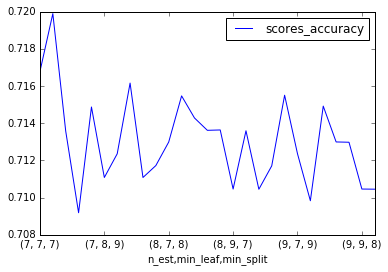

In [43]:
indexed_df = resultDataFrame.set_index(['n_est', 'min_leaf','min_split'])
indexed_df.plot(kind='line')

Useful links:

http://blog.yhat.com/posts/random-forests-in-python.html
https://www.dataquest.io/blog/machine-learning-python/
https://www.kaggle.com/c/titanic/details/getting-started-with-random-forests

http://datascience.stackexchange.com/questions/5226/strings-as-features-in-decision-tree-random-forest

In [55]:
def doCrossValidation(dataDataframe): 
    
    result = collections.defaultdict(list)

    # We loop to find the best parameter for our classifier.

    # --> les fenetres des valeurs possible doivent étre changé.
    for n_est in [1,10,100,1000]:
        for min_leaf in range(10,11):
            for min_split in range (10,11):

                # cross validation using RandomForestClassifier
                clf = RandomForestClassifier(n_jobs=-1, n_estimators=n_est, min_samples_leaf=min_leaf, min_samples_split=min_split)
                scores = cross_val_score(clf, dataDataframe[features], dataDataframe['rater'] , cv=10, scoring='accuracy')

                # adding result to the dic.
                result['min_leaf'].append(min_leaf)
                result['min_split'].append(min_split)
                result['n_est'].append(n_est)
                result['scores_accuracy'].append(np.mean(scores))

                print('min_leaf: '+str(min_leaf) +
                      ' min_split: '+str(min_leaf) +
                      ' n_est: '+str(n_est))
                print(np.mean(scores))
                
    resultDataFrame = pd.DataFrame.from_dict(result)
    resultDataFrame.head()
    indexed_df = resultDataFrame.set_index(['n_est', 'min_leaf','min_split'])
    indexed_df.plot(kind='line')
    return indexed_df

min_leaf: 10 min_split: 10 n_est: 1
0.688394992659
min_leaf: 10 min_split: 10 n_est: 10
0.708566506838
min_leaf: 10 min_split: 10 n_est: 100
0.708554713458
min_leaf: 10 min_split: 10 n_est: 1000
0.708554713458
min_leaf: 10 min_split: 10 n_est: 2000
0.708554713458


,,,scores_accuracy
n_est,min_leaf,min_split,
1,10,10,0.688395
10,10,10,0.708567
100,10,10,0.708555
1000,10,10,0.708555
2000,10,10,0.708555


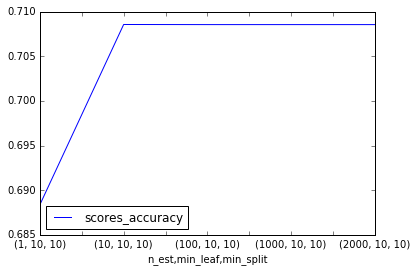

In [58]:
doCrossValidation(soccer_data_final)

min_leaf: 10 min_split: 10 n_est: 1
0.694649313142
min_leaf: 10 min_split: 10 n_est: 10
0.712332626336
min_leaf: 10 min_split: 10 n_est: 100
0.708554713458
min_leaf: 10 min_split: 10 n_est: 1000
0.708554713458
min_leaf: 10 min_split: 10 n_est: 2000
0.708554713458


,,,scores_accuracy
n_est,min_leaf,min_split,
1,10,10,0.694649
10,10,10,0.712333
100,10,10,0.708555
1000,10,10,0.708555
2000,10,10,0.708555


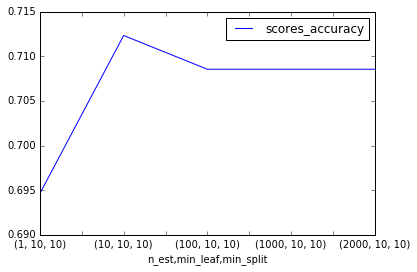

In [59]:
doCrossValidation(soccer_data_final)

In [ ]:
#soccer_data_clean.drop('birthday', axis=1, inplace=True)
#soccer_data_clean.drop('rater1', axis=1, inplace=True)
#soccer_data_clean.drop('rater2', axis=1, inplace=True)

> Vérifier que les notes pour la couleur

In [ ]:
#rfc = RandomForestClassifier()

x = soccer_data_clean[['games','victories','ties','defeats','goals','yellowCards','yellowReds','redCards','age']]
y = soccer_data_clean['rater']

#scores = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')
n_est = 10
result = collections.defaultdict(list)

#rfc = RandomForestClassifier()

#x = soccer_data_clean[['club','leagueCountry','height','weight','position','games','victories','ties','defeats','goals','yellowCards','yellowReds','redCards','refNum','refCountry','Alpha_3','meanIAT','nIAT','seIAT','meanExp','nExp','seExp','age']]
#y = soccer_data_clean['rater']

#scores = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')
#print(scores)

#rfc.fit(x, y)
#rfc.predict([23, 2, 1, 0])